In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pde_opt
from pde_opt.pde_model import PDEModel
from pde_opt.numerics.equations.cahn_hilliard import CahnHilliard2DPeriodic
from pde_opt.numerics.solvers import SemiImplicitFourierSpectral
from pde_opt.numerics.domains import Domain
from pde_opt.numerics.functions.mixer_mlp import Mixer2d
from pde_opt.numerics.functions.cnn import PeriodicCNN

import equinox as eqx
import diffrax

In [2]:
Nx = Ny = 64
Lx = Ly = 0.01 * Nx

domain = Domain(
    (Nx, Ny),
    (
        (-Lx / 2, Lx / 2),
        (-Ly / 2, Ly / 2),
    ),
    "dimensionless",
)

In [3]:
opt_model = PDEModel(
    equation_type=CahnHilliard2DPeriodic,
    domain=domain,
    solver_type=SemiImplicitFourierSpectral,
)

In [4]:
params = {"kappa": 0.002, "mu": lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c), "D": lambda c: jnp.ones_like(c)}

solver_params = {"A": 0.5}

key = jax.random.PRNGKey(0)
y0 = jnp.clip(0.01 * jax.random.normal(key, (Nx, Ny)) + 0.5, 0.0, 1.0)
ts = jnp.linspace(0.0, 0.02, 100)

In [5]:
sol = opt_model.solve(params, y0, ts, solver_params, dt0=0.000001, max_steps=1000000)

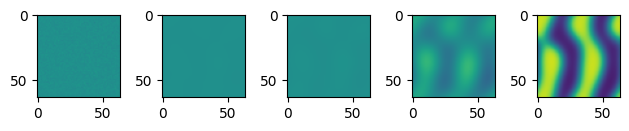

In [6]:
fig, ax = plt.subplots(1, 5)
ax[0].imshow(sol[0], vmin=0.0, vmax=1.0)
ax[1].imshow(sol[10], vmin=0.0, vmax=1.0)
ax[2].imshow(sol[20], vmin=0.0, vmax=1.0)
ax[3].imshow(sol[50], vmin=0.0, vmax=1.0)
ax[4].imshow(sol[-1], vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.savefig("original_solution.png")

In [7]:
# model = Mixer2d(
#     (1, Nx, Ny),
#     8,
#     32,
#     8,
#     32,
#     2,
#     key=jax.random.PRNGKey(0),
# )

# model = eqx.filter_jit(model)

model = PeriodicCNN(
    in_channels=1,
    hidden_channels=(32, 64, 64),
    out_channels=1,
    kernel_size=3,
    key=jax.random.PRNGKey(0),
)

model = eqx.filter_jit(model)

In [11]:
tmp = model(jnp.zeros((Nx,Ny)))

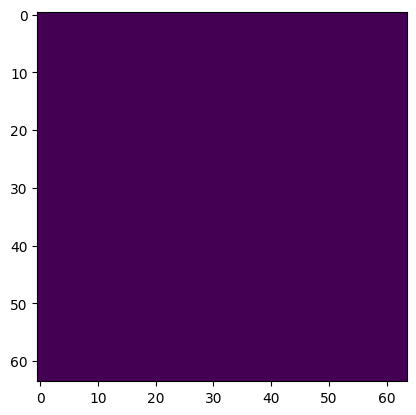

In [12]:
plt.imshow(tmp)

In [13]:
data = {}
data['ys'] = sol
data['ts'] = ts

inds = [[30,40,50], [50,60,70], [70,80,90]]

init_params = {
    "mu": model,
}

static_params = {
    "kappa": 0.002,
    "D": lambda c: jnp.ones_like(c),
}

solver_parameters = {
    "A": 0.5,
}

weights = {
    "mu": None
}

lambda_reg = 0.0


In [15]:
ts = jnp.linspace(0.0, 0.02, 100)
test_sol = opt_model.solve({**init_params, **static_params}, y0, ts, solver_parameters, dt0=0.000001, max_steps=1000000)

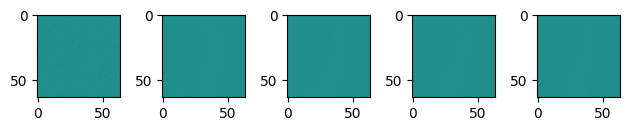

In [16]:
fig, ax = plt.subplots(1, 5)
ax[0].imshow(test_sol[0], vmin=0.0, vmax=1.0)
ax[1].imshow(test_sol[10], vmin=0.0, vmax=1.0)
ax[2].imshow(test_sol[20], vmin=0.0, vmax=1.0)
ax[3].imshow(test_sol[50], vmin=0.0, vmax=1.0)
ax[4].imshow(test_sol[-1], vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.savefig("test.png")

In [17]:
res = opt_model.train(data, inds, init_params, static_params, solver_parameters, weights, lambda_reg, method="mse", max_steps=10)

Loss on this step: 0.027177389711141586, Loss on the last accepted step: 0.0, Step size: 1.0
Loss on this step: 0.02648204378783703, Loss on the last accepted step: 0.027177389711141586, Step size: 1.0
Loss on this step: 0.025648383423686028, Loss on the last accepted step: 0.02648204378783703, Step size: 1.0
Loss on this step: 0.02452291175723076, Loss on the last accepted step: 0.025648383423686028, Step size: 1.0
Loss on this step: 0.02277037501335144, Loss on the last accepted step: 0.02452291175723076, Step size: 1.0
Loss on this step: 0.019473586231470108, Loss on the last accepted step: 0.02277037501335144, Step size: 1.0
Loss on this step: 0.011965378187596798, Loss on the last accepted step: 0.019473586231470108, Step size: 1.0
Loss on this step: 0.09716169536113739, Loss on the last accepted step: 0.011965378187596798, Step size: 0.5
Loss on this step: 0.01201808825135231, Loss on the last accepted step: 0.011965378187596798, Step size: 0.25
Loss on this step: 0.0099541489034

In [18]:
opt_sol = opt_model.solve(res, y0, ts, solver_parameters, dt0=0.000001, max_steps=1000000)

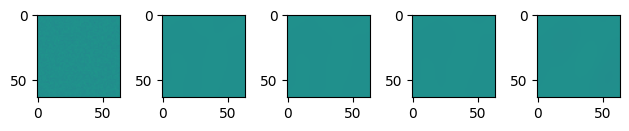

In [19]:
fig, ax = plt.subplots(1, 5)
ax[0].imshow(opt_sol[0], vmin=0.0, vmax=1.0)
ax[1].imshow(opt_sol[10], vmin=0.0, vmax=1.0)
ax[2].imshow(opt_sol[20], vmin=0.0, vmax=1.0)
ax[3].imshow(opt_sol[50], vmin=0.0, vmax=1.0)
ax[4].imshow(opt_sol[-1], vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.savefig("optimized_solution.png")

